# Experiments [1.1.1] [1.1.2] - Rationales Frequencies

In [1]:
def param_default():
    return {
        'model': 'codeparrot',
        'dataset' : 'DC_SG_BD', #### CHANGE
        'modality' : 'nl_sc',
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        'num_experiments' : 30, 
        'bootstrapping_size': 500,
        ######## INPUT 
        'global_taxonomy_results': '/workspaces/code-rationales/data/global_taxonomy_results/gpt',
        'grouping_results': '/workspaces/code-rationales/data/experiments/grouping_results', 
        ######## OUTPUT
        'quantitative_results' : '/workspaces/code-rationales/data/experiments/quantitative_results',
    }
    
params = param_default()

## Source Code

In [2]:
import json
import pandas as pd
import numpy as np
import math
from statistics import NormalDist

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pd.options.display.float_format = '{:.2f}'.format

In [3]:
from code_rationales.taxonomies import *
import os.path

### Frequency Dataframes

In [4]:
def flat_global_results(experiment_global_result: dict):
    flatten_results = { key: [] for key in experiment_global_result.keys() } ## There are 31 fixed categories
    for target_key, rationales in experiment_global_result.items():
        for rational_key, rational_values in rationales.items():
            flatten_results[rational_key] += rational_values
    return flatten_results

In [5]:
def create_frequencies_dataframe(experients_global_results: list):
    frequencies_df = pd.DataFrame(columns=experients_global_results[0].keys())
    for experiment_global_result in experients_global_results:
        rationales_results = flat_global_results(experiment_global_result)
        frequencies_df = frequencies_df.append({key: len(value) for key, value in rationales_results.items()}, ignore_index=True)
    frequencies_df = frequencies_df.fillna(0)   
    return frequencies_df


### Groupings

In [6]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'

In [7]:
def store_groupings(global_results: list, path:str):
    with open(path, 'w') as output_file: 
        json.dump(global_results, output_file)

In [8]:
def open_groupings(path:str):
    with open(path, 'r') as output_file:
        data = json.load(output_file)
    return data

In [9]:
def get_experiments_results(dataset_id:str , name:str):
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][params['dataset']] + '_' + name + '.json'
    if os.path.isfile(file_path):
        return open_groupings(file_path)
    experiment_paths = [get_experiment_path(params['global_taxonomy_results'], params['datasets'][dataset_id], exp) for exp in range(params['num_experiments'])]
    experiment_global_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_global_results.append(json.loads(file.read()))
    store_groupings(experiment_global_results, file_path)
    return experiment_global_results

### Statistics 

In [10]:
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [11]:
def confidence_intervals_large_samples(data, confidence=0.95):
    """
    @confidence: confidence interval 
    @return: tuple (lowerbound, uperbound, h-value)
    """
    dist = NormalDist.from_samples( data )
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [12]:
def boostrap_dictionary(dictionary: dict, size):
    boostrapped_dict = {}
    for key, values in dictionary.items():
        if values:
            boostrapped_dict[key] = bootstrapping(values, np.mean, size)
    return boostrapped_dict

### Calculate statistics and get results DF

In [13]:
### CREATE GROUP FREQUENCY RESULTS
def calculate_results(global_dataframe):
    results_df = pd.DataFrame(columns=['type', 'group', 'category', 'mean', 'median', 'std', 'ci', 'total'])
    for category in global_dataframe.columns:
        experiments_values = global_dataframe[category].tolist()
        try:
            group = [key for key, value in global_groups().items() if category in value][0] ## Mapping from taxonomy groups
        except Exception as e:
            print(e)
        results_df = results_df.append({
            'type': group.split('_')[0], 
            'group': group, 
            'category': category, 
            'median' : np.median(experiments_values),
            'mean' : np.mean(experiments_values), 
            'std' : np.std(experiments_values),
            'ci' : confidence_intervals_large_samples(experiments_values),
            'total' : global_dataframe[category].sum()
        }, ignore_index=True)
    return results_df.sort_values(by='median', ascending=False).reset_index(drop=True)

In [ ]:
def get_freqcuencies_df():
    frequencies_df = pd.DataFrame(columns=['category', 'total', 'dataset_id'])
    for dataset_id in params['datasets'].keys():
        dataset_global_results = get_experiments_results('SC', 'level_1')
        global_frequencies_dataframe_results = calculate_results(create_frequencies_dataframe(dataset_global_results)).sort_values(by=['group','mean'],ascending=[True, False])
        global_frequencies_dataframe_results.to_csv(params['quantitative_results'] + '/' + params['model'] + '/' + params['modality']  + '/' + params['datasets'][params['dataset']] + '_frequencies' + '.csv', index=False)
        dataset_frequency_df = global_frequencies_dataframe_results[['category', 'total']].copy()
        dataset_frequency_df['dataset_id'] = [dataset_id]*dataset_frequency_df.shape[0]
        frequencies_df = pd.concat([frequencies_df,dataset_frequency_df], ignore_index=True)
    return frequencies_df

## Experiment 1.1.1
Top 20 most frequent level_1 concepts

In [16]:
frequencies_df = get_freqcuencies_df()
frequencies_df

,category,total,dataset_id
0,excluded,20568908,SG_BD
1,nl_preposition,1544956,SG_BD
2,nl_determiner,1382492,SG_BD
3,nl_conjunction,499685,SG_BD
4,nl_adverb,297293,SG_BD
...,...,...,...
131,loops,60457,DC
132,bool,57461,DC
133,asserts,34443,DC
134,unknown,8608041,DC


In [ ]:
top_20_categories = frequencies_df[frequencies_df['dataset_id'] == 'DC_SG_BD'].sort_values(by='total')

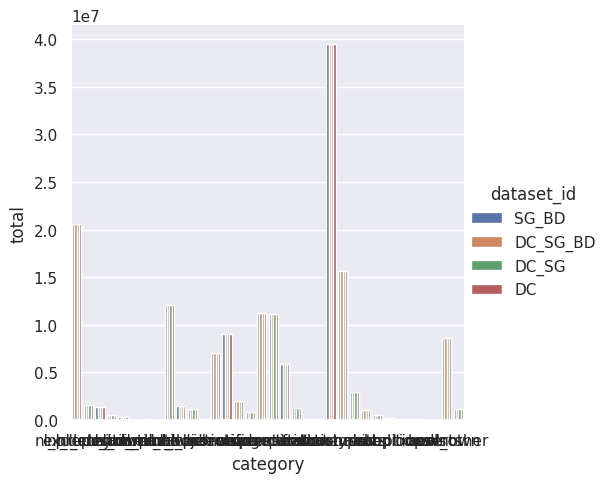

In [20]:
g = sns.catplot(x='category', y='total', hue='dataset_id', data=frequencies_df, kind='bar', height=5, aspect=1)